## 製造數據科學作業四

#### 經濟四b09303047林奕霆

#### 第一題

**(a)**

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
try:
    raw_df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
except:
    raw_df = pd.read_csv('creditcard.csv')

In [5]:
labels=["Genuine","Fraud"]

fraud_or_not = raw_df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=raw_df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

Data preprocessing

In [6]:
df = raw_df.copy()
df.drop_duplicates(inplace=True)
df = df.drop('Time', axis=1)


In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [8]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df
col_names = ['Amount']
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)
rf = RandomForestClassifier(n_estimators=100, random_state=13)



In [12]:
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.8030303  0.74242424 0.76119403 0.87878788 0.65151515]
Average Cross Validation Recall score: 0.7673903211216644


In [12]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [ 10, 12],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 12, 'n_estimators': 100, 'random_state': 13}
Best score: 0.7734509271822705


印出rf預測結果

In [13]:
y_pred = grid_rf.predict(X_test)
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[84972     4]
 [   33   109]]


In [20]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.767606,0.964602,0.854902,0.999565


1. Random OverSampling

In [12]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 198277 / 50.0 % of the dataset
Frauds: 198277 / 50.0 % of the dataset


In [9]:
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))

In [10]:
score2 = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.83333333 0.72727273 0.74626866 0.86363636 0.65151515]
Average Cross Validation Recall score: 0.7644052464947987


In [13]:
# 由參考資料取得最佳參數直接訓練模型
best_params = {
    'max_depth': 4,
    'n_estimators': 50,
    'random_state': 13
}

random_oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)  # Adjust sampling_strategy if needed
random_forest_classifier = RandomForestClassifier(**best_params)

# Create the pipeline with RandomOverSampler and RandomForestClassifier
random_overs_pipeline = make_pipeline(random_oversampler, random_forest_classifier)

# Fit the pipeline on the training data
random_overs_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred2 = random_overs_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred2)

over_rf_Recall = recall_score(y_test, y_pred2)
over_rf_Precision = precision_score(y_test, y_pred2)
over_rf_f1 = f1_score(y_test, y_pred2)
over_rf_accuracy = accuracy_score(y_test, y_pred2)

print(cm)

ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_rf_accuracy)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

[[84914    62]
 [   28   114]]


,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.802817,0.647727,0.716981,0.998943


2. Random Undersampling

In [14]:
from imblearn.under_sampling import RandomUnderSampler
# define oversampling strategy
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 331 / 50.0 % of the dataset
Frauds: 331 / 50.0 % of the dataset


In [24]:
from imblearn.pipeline import Pipeline, make_pipeline

random_under_pipeline = make_pipeline(RandomUnderSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))

In [20]:
score3 = cross_val_score(random_under_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3))
print("Average Cross Validation Recall score: {}".format(score3.mean()))

Cross Validation Recall Scores are: [0.92424242 0.89393939 0.86567164 0.96969697 0.84848485]
Average Cross Validation Recall score: 0.9004070556309361


In [15]:
best_params = {
    'max_depth': 4,
    'n_estimators': 50,
    'random_state': 13
}

random_undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Adjust sampling_strategy if needed
random_forest_classifier = RandomForestClassifier(**best_params)

# Create the pipeline with RandomOverSampler and RandomForestClassifier
random_under_pipeline = make_pipeline(random_undersampler, random_forest_classifier)

# Fit the pipeline on the training data
random_under_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred3 = random_under_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred3)

under_rf_Recall = recall_score(y_test, y_pred3)
under_rf_Precision = precision_score(y_test, y_pred3)
under_rf_f1 = f1_score(y_test, y_pred3)
under_rf_accuracy = accuracy_score(y_test, y_pred3)

print(cm)

ndf = [(under_rf_Recall, under_rf_Precision, under_rf_f1, under_rf_accuracy)]

under_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
under_rf_score.insert(0, 'Random Forest with', 'Random Undersampling')
under_rf_score

[[84728   248]
 [   25   117]]


,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Random Undersampling,0.823944,0.320548,0.461538,0.996793


3. SMOTE

In [28]:
from imblearn.over_sampling import SMOTE

smote_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
score3 = cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3))
print("Average Cross Validation Recall score: {}".format(score3.mean()))

Cross Validation Recall Scores are: [0.86363636 0.83333333 0.76119403 0.87878788 0.72727273]
Average Cross Validation Recall score: 0.8128448665762098


In [11]:
best_params = {
    'max_depth': 6,
    'n_estimators': 50,
    'random_state': 13
}
from imblearn.over_sampling import SMOTE

random_forest_classifier = RandomForestClassifier(**best_params)

# Create the pipeline with RandomOverSampler and RandomForestClassifier
smote_pipeline = make_pipeline(SMOTE(random_state=42), 
                              random_forest_classifier)
# Fit the pipeline on the training data
smote_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred4 = smote_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred4)

smote_rf_Recall = recall_score(y_test, y_pred4)
smote_rf_Precision = precision_score(y_test, y_pred4)
smote_rf_f1 = f1_score(y_test, y_pred4)
smote_rf_accuracy = accuracy_score(y_test, y_pred4)

print(cm)

ndf = [(smote_rf_Recall, smote_rf_Precision,smote_rf_f1, smote_rf_accuracy)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smote_rf_score.insert(0, 'Random Forest with', 'smote')
smote_rf_score

[[84621   355]
 [   21   121]]


,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,smote,0.852113,0.254202,0.391586,0.995583


**(b)**  
由以上三種方法，我最建議使用SMOTE，原因是他的Recall 分數最高，由於信用卡詐欺事件的出現往往具有相當高的嚴重性，有效地識別可能涉及詐欺的交易事件並對其進行監控，往往能夠減少重大損失。


In [17]:
predictions = pd.concat([under_rf_score, over_rf_score, smote_rf_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Random Forest with,Recall,Precision,F1 Score,Accuracy
2,smote,0.852113,0.254202,0.391586,0.995583
0,Random Undersampling,0.823944,0.320548,0.461538,0.996793
1,Random Oversampling,0.802817,0.647727,0.716981,0.998943


雖然smote的Recall分數較高，然而他卻有較低的f1 score與precision，而在三種方法中accuracy最高的是random oversampling，但其recall卻最低。

**(c)**

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

# 不同的生成比例
smote_ratios = np.arange(0.1, 1.1, 0.1)
best_params = {
    'max_depth': 6,
    'n_estimators': 50,
    'random_state': 13
}
fixed_threshold = 0.5  # 設定固定 threshold

# 初始化結果存儲列表
fpr_list = []
fnr_list = []

# 遍歷不同生成比例
for smote_ratio in smote_ratios:
    # 創建 SMOTE 實例，設定生成比例
    smote = SMOTE(sampling_strategy=smote_ratio)
    
    # 運用 SMOTE 生成新樣本
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f'SMOTE Ratio = {smote_ratio:.1f}, Positive Class Ratio = {np.mean(y_resampled):.2f}')
    
    # 初始化 Random Forest 分類器
    rf_model = RandomForestClassifier(**best_params)
    
    # 訓練模型
    rf_model.fit(X_resampled, y_resampled)
    
    # 預測概率
    y_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # 將所有預測概率調整為固定 threshold
    y_pred_fixed_threshold = (y_proba >= fixed_threshold).astype(int)
    
    # 計算混淆矩陣
    cm = confusion_matrix(y_test, y_pred_fixed_threshold)
    
    # 計算偽陽性率（FPR）和偽陰性率（FNR）
    fpr = cm[0, 1] / (cm[0, 1] + cm[1, 1])
    fnr = cm[1, 0] / (cm[1, 0] + cm[0, 0])
    
    # 將結果添加到列表中
    fpr_list.append(fpr)
    fnr_list.append(fnr)
    print(fpr, fnr)




SMOTE Ratio = 0.1, Positive Class Ratio = 0.09
0.18840579710144928 0.0003530242409978819
SMOTE Ratio = 0.2, Positive Class Ratio = 0.17
0.2222222222222222 0.0003530491679807941
SMOTE Ratio = 0.3, Positive Class Ratio = 0.23
0.25 0.00036483464752265504
SMOTE Ratio = 0.4, Positive Class Ratio = 0.29
0.3090909090909091 0.0003295940108059751
SMOTE Ratio = 0.5, Positive Class Ratio = 0.33
0.39267015706806285 0.00030614527770909136
SMOTE Ratio = 0.6, Positive Class Ratio = 0.37
0.5245901639344263 0.0003063364516813158
SMOTE Ratio = 0.7, Positive Class Ratio = 0.41
0.5568181818181818 0.000294623706601928
SMOTE Ratio = 0.8, Positive Class Ratio = 0.44
0.6225806451612903 0.0002947835109895293
SMOTE Ratio = 0.9, Positive Class Ratio = 0.47
0.7241379310344828 0.00025979240225310865
SMOTE Ratio = 1.0, Positive Class Ratio = 0.50
0.751578947368421 0.00028354382524248907


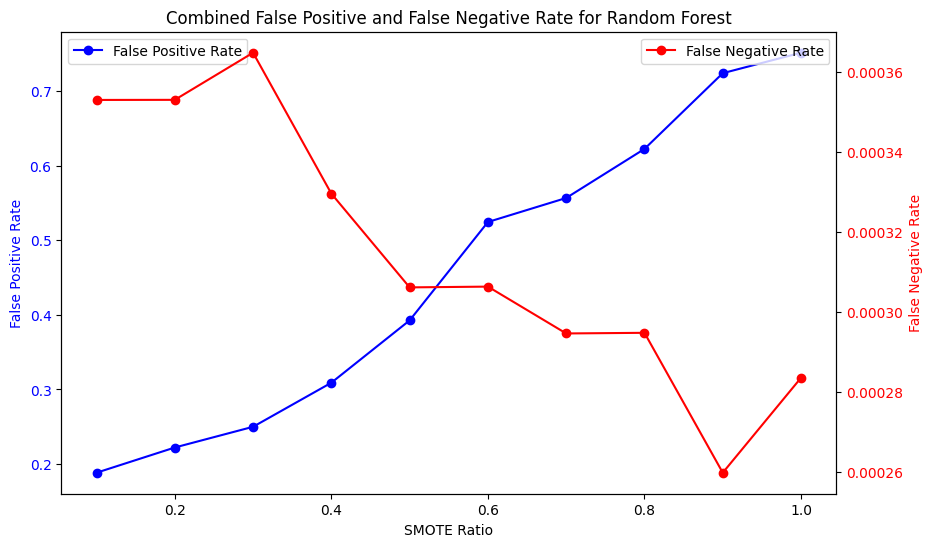

In [12]:

# 創建圖表和兩個 y 軸
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# 畫折線圖，第一條曲線在左 y 軸上
ax1.plot(smote_ratios, fpr_list, marker='o', label='False Positive Rate', color='blue')
ax1.set_xlabel('SMOTE Ratio')
ax1.set_ylabel('False Positive Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 第二條曲線在右 y 軸上
ax2.plot(smote_ratios, fnr_list, marker='o', label='False Negative Rate', color='red')
ax2.set_ylabel('False Negative Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# 共享 x 軸標籤
plt.title('Combined False Positive and False Negative Rate for Random Forest')
plt.show()


由上圖敏感性分析可以觀察到，當數據越平衡，FPR(偽陽率)會越來越高，而FNR(偽陰率)會越來越低，這可能是因為當Label為1的數據在訓練及越來越多時，模型更能購判斷出信用卡詐欺事件，但也更容易將非信用詐欺事件與非正常交易搞混。就上圖觀察而言，由於信用卡詐欺事件的嚴重性相當高，我會將SMOTE Ratio，選在0.9，由於該比例的FNR相對最低，且無法判斷出該交易為詐欺事件的成本也高出很多。


**(d)**  
我認為特徵挑選應在資料平衡之後，這是因為特徵挑選會針對資料集做重要特徵的篩選，若我們在資料平衡前就做篩選，則可能會選到一些針對不重要的資料(Outliers)，又或是對分辨少數的label較差的特徵，這可能會使我們在進行預測時，無法更有效地分辨出資料平衡前較少的label。

**(e)**
我認為這篇文章可以再補充翰海進以下幾個部分:

1. 將不同種Data balance的方法講解得更仔細，並列出各種data balance方法適合應用的情境
2. 增加各多評分機制的方法，這篇文章有提到recall, ROC等衡量模型表現的方法，還可以再增加期的衡量模型的方法如前一提的敏感性分析等。  
除此之外我認為這篇文章有很多可學習之處，也講得相當精細，例如提到為何不刪除outliers的原因。


## 第二題

**(a)**

1. 染色體編碼  
首先將染色體表示為一組工件的作業加工順序，一個基因代表一個工件的加工作業，根據工件在染色體出現的次數，來得知各個工件目前的加工作業，再來對應各工件的加工機台及加工時間，藉此來進行排程。  
此排程問題具有20個工件15台機台，那一個染色體將會由 20 *15 個基因所組成，因為每個工件在每台機台只會被加工一次，共要被 15 台機台加工，所以每個工件在染色體裡將會出現 15 次。

2. 初始解生成  
隨機生成一些初始的排程，我們假設**母體大小為50**(也就是有50個染色體)，每個染色體共有 20 x 15 = 300 個基因，並可以使用不同的啟發式方法，例如優先安排處理時間較長的工作或是優先安排處理時間較短的工作。



3. 交配  
一開始會先產生一組用來選擇親代染色體的隨機序列，接著從序列中，兩個兩個抓出來，我們假設**交配率為0.7**來決定是否要進行交配，如果被選中，則採用雙點交配法，產生兩個子代，並取代原本的母代染色體。



4. 修復  
由於上面進行交配的動作，會導致有些染色體內的工件出現次數會小於15或大於15，而形成一個不可行的排程解，所以此步驟必須針對不可行的染色體進行修復動作，使它成為一個可行排程。



5. 突變  
依據 mutation selection rate 決定染色體中有多少百分比的基因要進行突變，假設 **mutation selection rate 為0.3**，則總共300個基因我們會隨機指定90個基因進行突變。


6. 選擇  
我們採用輪盤法進行選擇: 首先計算每個個體的適應度值(該值為完工時間的倒數)，而後計算每個個體被選中的概率，且概率與適應度成正比，最後將這些概率形成一個輪盤，輪盤的整體長度等於所有個體的總適應度，並在輪盤上隨機選擇一個位置，該位置所屬的區間所代表的個體就是被選中的個體。  
此方法可以使適應度較高的個體被選中的概率較大，但不保證適應度最高的個體一定會被選中，因此具有一定的隨機性。這種方法有助於保持多樣性，同時更有可能選擇適應度較高的個體。


7. 輸出最佳結果  
等達到**最大迭代次數**(假設為2000次)或適應度達到某個閾值時，輸出在所有迭代中找到的最好排程結果、該結果的完工時間以及程式執行時間。

**(b)**

以下為修復方法:  
1. 拒絕不可行染色體並生成新染色體： 最簡單的修復方法是拒絕不可行的染色體，並嘗透過將重複排程的機器改為未經過處理的機器，試重新生成一個合乎原則的染色體。
2. 多次突變： 將不可行染色體標記為需要修復，然後在後續的突變操作中針對這些標記進行特殊處理。如此會產生多次突變，直到染色體變得合法。

**(c)**

In [1]:
import pandas as pd
import numpy as np
import time
import copy
import matplotlib.pyplot as plt

# 初始化設置
pt_tmp = pd.read_excel("JSP_dataset.xlsx", sheet_name="Processing Time", index_col=[0])
ms_tmp = pd.read_excel("JSP_dataset.xlsx", sheet_name="Machines Sequence", index_col=[0])
print(pt_tmp)
dfshape = pt_tmp.shape
num_mc = dfshape[1]  # number of machines
num_job = dfshape[0]  # number of jobs
num_gene = num_mc * num_job  # number of genes in a chromosome

pt = [list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
ms = [list(map(int, ms_tmp.iloc[i])) for i in range(num_job)]

# 輸入參數
population_size=50
crossover_rate=0.7
mutation_rate=0.3
mutation_selection_rate=0.2
num_mutation_jobs=round(num_gene*mutation_selection_rate)
num_iteration=2000

start_time = time.time()

Tbest = 999999999999999
best_list, best_obj = [], []
population_list = []
makespan_record = []
current_best_record = []  

for i in range(population_size):
    nxm_random_num = list(np.random.permutation(num_gene))
    population_list.append(nxm_random_num)
    for j in range(num_gene):
        population_list[i][j] = population_list[i][j] % num_job

for n in range(num_iteration):
    Tbest_now = 99999999999
    '''-------- two point crossover --------'''
    parent_list=copy.deepcopy(population_list)
    offspring_list=copy.deepcopy(population_list)
    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
    
    for m in range(int(population_size/2)):
        crossover_prob=np.random.rand()
        if crossover_rate>=crossover_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]
            cutpoint=list(np.random.choice(num_gene, 2, replace=False))
            cutpoint.sort()
        
            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
            offspring_list[S[2*m+1]]=child_2[:]
        
    
    '''----------repairment-------------'''
    for m in range(population_size):
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            else:
                count=0
                job_count[i]=[count,0]
            if count>num_mc:
                larger.append(i)
            elif count<num_mc:
                less.append(i)
                
        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc:                    
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==num_mc:
                        break     
    
    '''--------mutatuon--------'''   
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate >= mutation_prob:
            m_chg=list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) # chooses the position to mutation
            t_value_last=offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position
  
    
    '''--------fitness value(calculate makespan)-------------'''
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # parent and offspring chromosomes combination
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_keys=[j+1 for j in range(num_mc)]
        m_count={key:0 for key in m_keys}
        
        for i in total_chromosome[m]:
            gen_t=int(pt[i][key_count[i]])
            gen_m=int(ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t
            
            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]
            
            key_count[i]=key_count[i]+1
    
        makespan=max(j_count.values())
        chrom_fitness.append(1/makespan)
        chrom_fit.append(makespan)
        total_fitness=total_fitness+chrom_fitness[m]

    
    '''----------selection(roulette wheel approach)----------'''
    pk,qk=[],[]
    
    for i in range(population_size*2):
        pk.append(chrom_fitness[i]/total_fitness)
    for i in range(population_size*2):
        cumulative=0
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)
    
    selection_rand=[np.random.rand() for i in range(population_size)]
    
    for i in range(population_size):
        if selection_rand[i]<=qk[0]:
            population_list[i]=copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0,population_size*2-1):
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break
    '''----------comparison----------'''
    for i in range(population_size*2):
        if chrom_fit[i]<Tbest_now:
            Tbest_now=chrom_fit[i]
            sequence_now=copy.deepcopy(total_chromosome[i])
    if Tbest_now <= Tbest:
        Tbest = Tbest_now
        sequence_best = copy.deepcopy(sequence_now)

    makespan_record.append(Tbest)  # Keep only this append inside the if-statement

    current_best_record.append(Tbest_now)  # record the best current best fitness value




       O1  O2  O3  O4  O5  O6  O7  O8  O9  O10  O11  O12  O13  O14  O15
Time                                                                   
J1     25  75  75  76  38  62  38  59  14   13   46   31   57   92    3
 J2    67   5  11  11  40  34  77  42  35   96   22   55   21   29   16
 J3    22  98   8  35  59  31  13  46  52   22   18   19   64   29   70
 J4    99  42   2  35  11  92  88  97  21   56   17   43   27   19   23
 J5    50   5  59  71  47  39  82  35  12    2   39   42   52   65   35
 J6    48  57   5   2  60  64  86   3  51   26   34   39   45   63   54
J7     40  43  50  71  46  99  67  34   6   95   67   54   29   30   60
J8     59   3  85   6  46  49   5  82  18   71   48   79   62   65   76
J9     65  55  81  15  32  52  97  69  82   89   69   87   22   71   63
J10    70  74  52  94  14  81  24  14  32   39   67   59   18   77   50
J11    18   6  96  53  35  99  39  18  14   90   64   81   89   48   80
 J12   44  75  12  13  74  59  71  75  30   93   26   30   84   

**(d)**

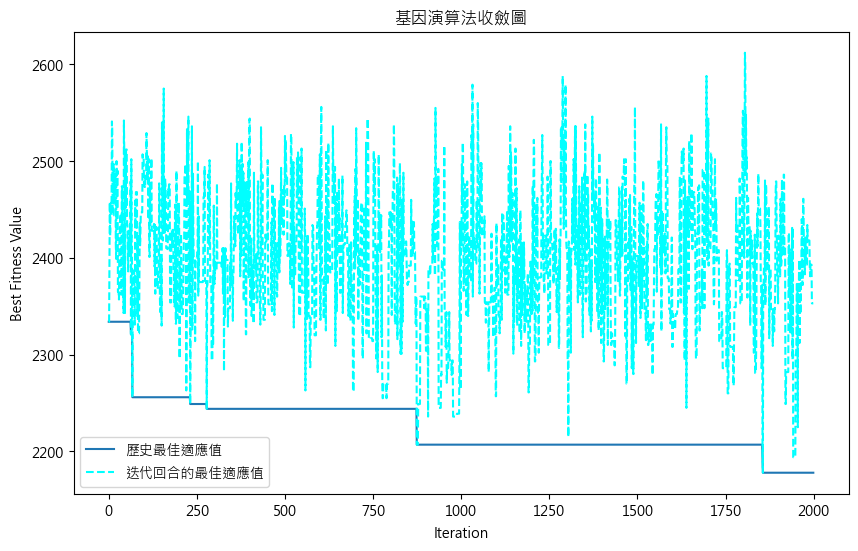

In [20]:
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.figure(figsize=(10, 6))
plt.plot(makespan_record, label='歷史最佳適應值')
plt.plot(current_best_record, label='迭代回合的最佳適應值', linestyle='--', color = 'aqua')
plt.title('基因演算法收斂圖')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness Value')
plt.legend()
plt.show()